# Final Project: Hybrid High Resolution Laplace, MPI + OpenACC
## Author: Rushan Jiang

The project is an extension of the laplace exercise in 33-456 ACP. The goal is to make a laplace solver which can solve 10K x 10K problem in high speed. The boundary condition is still a linear distribution from 0 to 100 celsius degrees.

Since the problem size is 100 times larger than that of the previous exercise, we need to use several devices to parallelize our code. In this project, MPI and OpenACC are used together to let multiple GPUs accelerate the laplace solver.

Here is the index of all files included in handin.tgz:

1. mpiacc_final.c: The source code of the laplace solver, written in C 

2. High_resolution.ipynb: The jupyter notebook which generates this pdf 

3. performance.csv: The data of recorded times and speedups 

4. output_large.txt: The solution matrix of the laplace solver. WARNING: This file is ~500MB and may takes some time to be opened 

5. README.txt: The file contains a biref introduction of laplace solver and instructions on how to run it

Note: For simulation results, it is better to use processes numbers which are factors of 10K: 1,2,4,5,8.

## How to run the laplace solver:
1. On bridges2 terminal, type: "interact -p GPU --gres=gpu:v100-32:8 -N 1 -t 30:00 -n 8" to get 8 GPUs

2. Compile the code using: "mpicc -acc -Minfo=accel mpiacc_final.c -o final_mpiacc". The command implement MPI and OpenACC together

3. Run with different number of processes(GPUs) and record the time costs, for example: "mpirun -n 4 final_mpiacc" runs the code with 4 processes

4. Note: input the max iterations: a number > 3578 since the laplace solver converges after 3578 iterations

It is worth to note that the number of processes should not exceed the number of GPUs available. Otherwise, some GPUs may need to do work of several processes and slow down the program

In [3]:
import numpy as np
import numpy.random as random
from numpy import exp, cos, sin, sqrt, maximum
import matplotlib        as mpl
import matplotlib.pyplot as plt
import pandas as pd

## Visualization of the solution

The laplace solver will converge after 3578 iterations with error 0.01.

The solution in "output_large.txt" is generated by the program with 4 processes(GPUs). 

The below is a visualization of the right lower corner of the plate. Note that it is not enough to verify the solution

In [4]:
Temperature = np.loadtxt("output_large.txt")
print(np.shape(Temperature))

(10000, 10000)


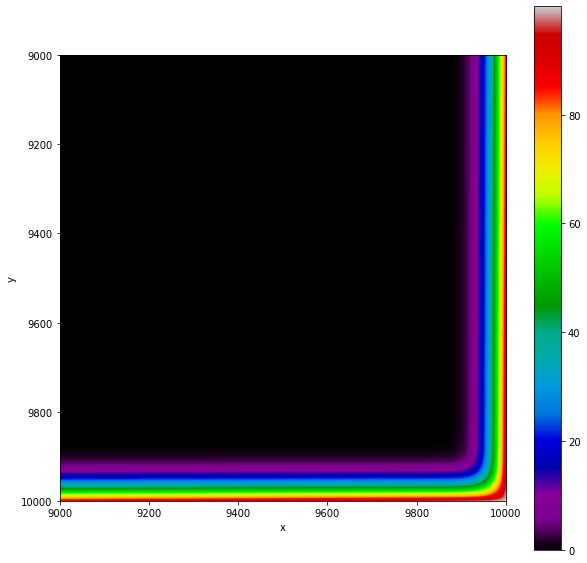

In [5]:
x_bound = 9000
y_bound = 9000
x_upper = 10000
y_upper = 10000
plt.figure(figsize=(10,10))
plt.imshow(Temperature[y_bound:y_upper, x_bound:x_upper], origin='upper', extent=[x_bound,x_upper,y_upper,y_bound],cmap='nipy_spectral')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

The visualization of the corner is not enough to veryfy the solution

According to the ghost row design, each PE's handle 2500 rows (plus the 2 ghost rows) in total. The ghost row will not appear in the final output.

To verify the solution, we need to show that there is no "bands" between PEs. The 7500th row is the boundary between PE 3 and PE 4. Hence, if there is no "bands" around this line, we can say the solution is corrrect.

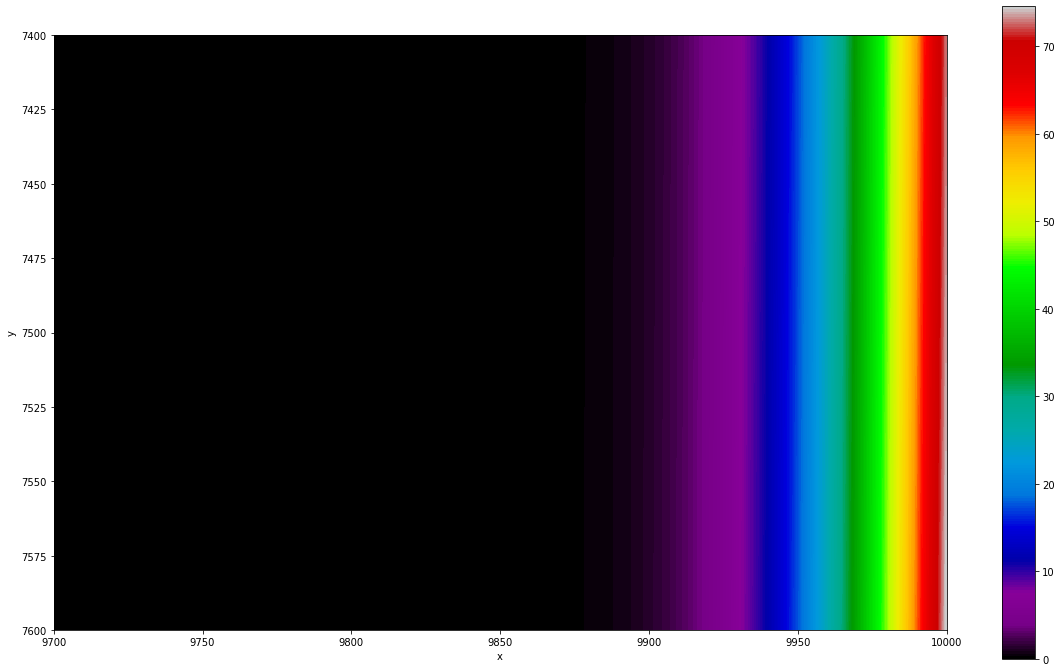

In [6]:
x_bound = 9700
y_bound = 7400
x_upper = 10000
y_upper = 7600
plt.figure(figsize=(20,12))
plt.imshow(Temperature[y_bound:y_upper, x_bound:x_upper], origin='upper', extent=[x_bound,x_upper,y_upper,y_bound],cmap='nipy_spectral')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

We can see that there is no band. Hence, the solution is correct.

## The speedup

There is 8 GPUs available on bridges2. Note: Requesting more than 8 GPUs (more than 1 node) may need to wait for several hours

We run the program with 1-8 GPUs

The total executing time (including initialization) and the executing time (not include initialization) are recorded

The result is shown in the following table. The speedup is based on the serial runtime: 2187s (by lecture) 

Important note: If the number of the threads is not a factor of 10K, we may lose one or two rows since every PE should handle the same number of rows. This may be an issue when one wants to generate a simulation results. However, for performance test purpose, it is totally fine: losing one or two rows did not affect the convergence and the executing time. Hence, running with 3,6,7 processes can still offer us useful points on the scability graph.


In [7]:
df = pd.read_csv('performance.csv')
print(df)

   Processes  GPUs    Time    Speedup1  Time_no_ini    Speedup2
0          1     1  24.458   89.418595      23.9219   91.422504
1          2     2  11.750  186.127660      11.3400  192.857143
2          3     3   8.490  257.597173       7.8000  280.384615
3          4     4   6.870  318.340611       6.0500  361.487603
4          5     5   6.100  358.524590       5.1100  427.984344
5          6     6   5.760  379.687500       4.4300  493.679458
6          7     7   5.510  396.914700       3.9900  548.120301
7          8     8   5.350  408.785047       3.6700  595.912806


To see the scaling, we make a plot of speedup versus the number of GPUs

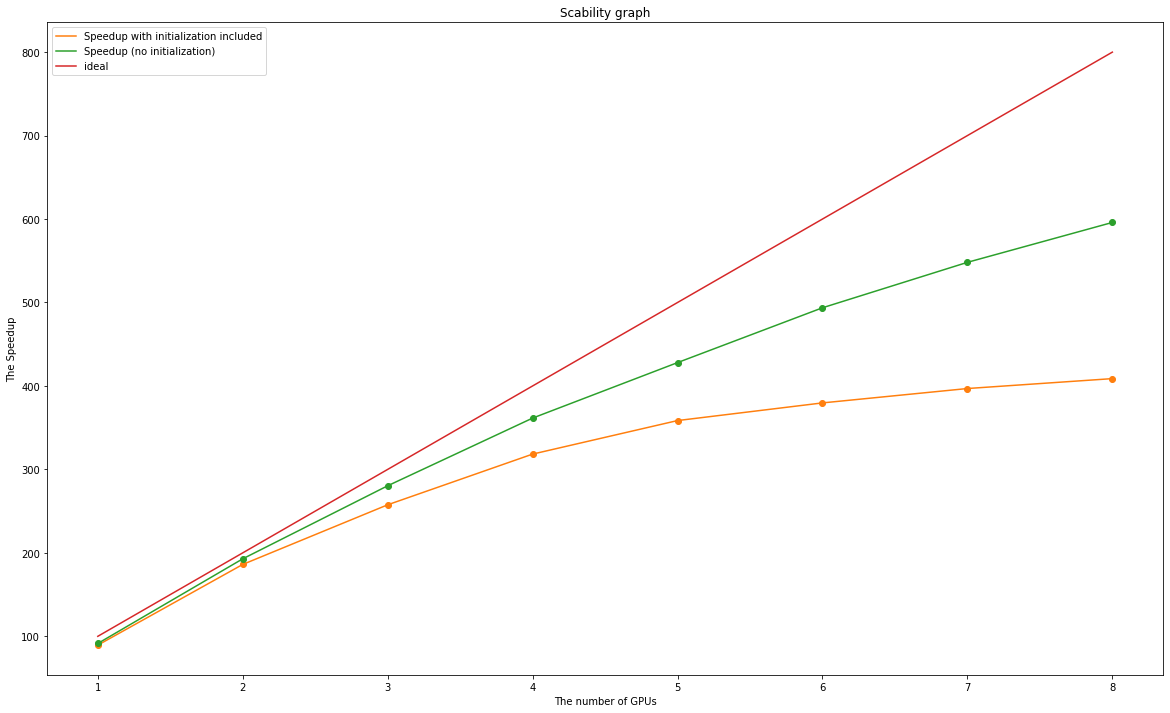

In [8]:
plt.figure(figsize=(20,12))
plt.plot(df.GPUs, df.Speedup1, "C1", label = "Speedup with initialization included")
plt.plot(df.GPUs, df.Speedup1, "C1o")
plt.plot(df.GPUs, df.Speedup2, "C2", label = "Speedup (no initialization)")
plt.plot(df.GPUs, df.Speedup2, "C2o")
plt.plot(df.GPUs, 100*df.GPUs,"C3", label = "ideal")
plt.xlabel("The number of GPUs")
plt.ylabel("The Speedup")
plt.title("Scability graph")
plt.legend()
plt.show()

The red line is the ideal case, which the speedup increase linearly as the number of GPUs increase. 

The green line is the speedup not including initialization. The yellow line is the speedup including initialization.

From the plot, we can see that the green is closer to the ideal case and the green and yellow deviates more and more as we increase the number of GPUs. The latter observation is due to Amdahl's Law. In the laplace solver, the initialization process requires huge amount of data transfer which cannot be parallelized. Hence, as we increase the number of GPUs, the initialization makes up a larger part of the executing time and curving down the speedup line. 

Apart from Amdahl's Law, the green line shows a trend of increasing speedup when getting more GPUs. It shows that the parallel part of the laplace solver is well handled by multiple devices using MPI+OpenACC.

## Conclusion

The project implements a laplace solver for 10K x 10K plate using MPI + OpenACC. The laplace solver will converge after 3578 iterations with error 0.01. Based on the running times with different number of GPUs, we can say that the parallel part is well parallelized by multiple devices (More GPUs, larger speedup). However, it has to be acknowledged that the initialization procedure of the laplace solver cannot be parallelized. Hence, the initilaization will make up more part as we add GPUs and slow down the increase of the speedup. In other words, for certain large number of GPUs, adding on more process will have little effect on the executing runtime (almost all the running time is for the initialization). In conclusion, the MPI+OpenACC improves the performance of laplace solver. The necessary data transfer between CPU and GPUs will be the major source of slowing down when increasing the number of GPUs.